In [1]:
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
import glob
from tqdm import tqdm
import pandas as pd
import requests

import json
import base64

import io
import json
from flask import Flask, jsonify, request
from PIL import Image
import csv
from model import U2NET, U2NETP
from torch.autograd import Variable
from matplotlib import pyplot as plt

app = Flask(__name__)


In [10]:
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def inference(net,input):

    # normalize the input
    tmpImg = np.zeros((input.shape[0],input.shape[1],3))
    input = input/np.max(input)

    tmpImg[:,:,0] = (input[:,:,2]-0.406)/0.225
    tmpImg[:,:,1] = (input[:,:,1]-0.456)/0.224
    tmpImg[:,:,2] = (input[:,:,0]-0.485)/0.229
    
#     print(tmpImg.shape)
#     plt.imshow(tmpImg)
#     plt.show()
    # convert BGR to RGB
    tmpImg = tmpImg.transpose((2, 0, 1))
#     print(tmpImg.shape)
    tmpImg = tmpImg[np.newaxis,:,:,:]
#     print(tmpImg.shape)
    tmpImg = torch.from_numpy(tmpImg)

    # convert numpy array to torch tensor
    tmpImg = tmpImg.type(torch.FloatTensor)
    tmpImg = tmpImg.to(device)
#     if torch.cuda.is_available():
#         tmpImg = Variable(tmpImg.cuda())
#     else:
    tmpImg = Variable(tmpImg)

    # inference
    d1,d2,d3,d4,d5,d6,d7= net(tmpImg)

    # normalization
    pred = 1.0 - d1[:,0,:,:]
    pred = normPRED(pred)

    # convert torch tensor to numpy array
    pred = pred.squeeze()
    pred = pred.cpu().data.numpy()

    del d1,d2,d3,d4,d5,d6,d7

    return pred

def sketch_sk(path):
    with torch.no_grad():
        img = cv2.imread(path)


#         img = cv2.resize(img, dsize = (2560, 1440))
        
        im_portrait = inference(net2,img)
        dst = cv2.resize((im_portrait*255).astype(np.uint8), dsize = (1280, 720))

    return dst

import torchvision.transforms as T
jitter = T.ColorJitter(brightness = (1.5, 1.5))

def sketch_bg(img):
    with torch.no_grad():
#         img = Image.open(path)
#         img = cv2.imread(path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h,w = img.shape[:2]
#         img = jitter(img)
        
#         img = np.array(img)
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
#         plt.imshow(img)
#         plt.show()
#         img = cv2.resize(img, dsize = (960, 540))
        
        im_portrait = inference(net1,img)
        dst = cv2.resize((im_portrait*255).astype(np.uint8), dsize = (w,h))
        
#         plt.imshow(dst,cmap='gray')
#         plt.show()

    return dst


def remove_bg(path):
    with torch.no_grad():
        img = cv2.imread(path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        r = 360 / float(h)
        dim = (int(w * r), 360)
        resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        im_portrait = inference(net3, resized_img)
        dst = cv2.resize((im_portrait*255).astype(np.uint8), dsize = (w, h))
        ret, mask2 = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        mask2_inv = cv2.bitwise_not(mask2)
        dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
        img_fg = cv2.bitwise_and(img, img, mask=mask2_inv)
        img_bg = cv2.bitwise_and(dst, dst, mask=mask2)
        dst = img_fg + img_bg
        dst = cv2.resize(dst, dsize = (1280, 720))
    return dst



def sketch_end(path):
    with torch.no_grad():
        img = cv2.imread(path)
        h, w = img.shape[:2]
        r = 360 / float(h)
        dim = (int(w * r), 360)
#         img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        im_portrait = inference(net3, resized_img)
        dst = cv2.resize((im_portrait*255).astype(np.uint8), dsize = (w, h))
        ret, mask2 = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        mask2_inv = cv2.bitwise_not(mask2)
        dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
        img_fg = cv2.bitwise_and(img, img, mask=mask2_inv)
        img_bg = cv2.bitwise_and(dst, dst, mask=mask2)
        dst = img_fg + img_bg
    
    with torch.no_grad():
#         factor = 0.25
#         w = 1280
#         h = 720
#         new_w = int(factor*w)
#         new_h = int(factor*h)
#         top = int((h-new_h)/2)
#         bottom = int((h-new_h)/2)
#         left = int((w-new_w)/2)
#         right = int((w-new_w)/2)
#         borderType = cv2.BORDER_CONSTANT
        
#         dst = cv2.resize(dst, dsize = (new_w, new_h))
#         dst = cv2.copyMakeBorder(dst, top, bottom, left, right, borderType, value=(255, 255, 255))
        
        im_portrait = inference(net2, dst)
#         dst = cv2.resize((im_portrait*255).astype(np.uint8), dsize = (w, h))
        dst = cv2.resize((im_portrait*255).astype(np.uint8), dsize = (1280, 720))
    return dst

In [3]:
def get_mask(path):
    with torch.no_grad():
        img = cv2.imread(path)
        h, w = img.shape[:2]
        r = 360 / float(h)
        dim = (int(w * r), 360)
        resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        im_portrait = inference(net3, resized_img)
        dst = cv2.resize((im_portrait*255).astype(np.uint8), dsize = (w, h))
        ret, mask2 = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#         contours, hierarchy = cv2.findContours(mask2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
#         if len(contours) > 0:
#             for cont in contours:
# #                 area = cv2.contourArea(cont)
# #                 if area < area_size:
#                 cv2.drawContours(mask2, [cont], -1, (100,0,0), 3)
        mask2 = cv2.resize(mask2, dsize = (1280, 720))
        mask2 = 255 - mask2
    return mask2

In [4]:
aug4 = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/saved_models/best/custom_aug4/custom_aug4_bce_itr_15477_train_0.527955_tar_0.038174.pth'
thin_APD = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/saved_models/best/train_APDrawingGAN/u2net_bce_itr_50000_train_0.806755_tar_0.059212.pth'
thin_custom = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/saved_models/best/train_custom/u2net_bce_itr_70000_train_0.805340_tar_0.090728.pth'
thick_erode2 = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/saved_models/best/train_custom_erode2/u2net_erode_bce_itr_70000_train_0.823957_tar_0.075138.pth'
thick_draw_nobg = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/saved_models/best/train_custom_draw_nobg/custom_nobg_bce_itr_60000_train_0.369949_tar_0.032807.pth'
thick_erode1 = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/saved_models/best/train_custom_erode/u2net_high_bce_itr_75000_train_0.858591_tar_0.078512.pth'
b2 = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/saved_models/custom_b2/custom_b2_bce_itr_14079_train_0.600803_tar_0.032533.pth'


net1 = U2NET(3,1)

torch_dict = torch.load(b2, map_location='cpu')

with torch.no_grad():
    net1.eval()

net1.load_state_dict(torch_dict)

device = 'cuda:2'
net1.to(device)
print('-------------------------')

-------------------------


In [41]:
def sketch(img_path):
    target_url = "http://aifolio.cafe24.com/sketch_predict/"
    
    img = cv2.imread(img_path)
    _, img_encoded = cv2.imencode('.png', img, params=[cv2.IMWRITE_JPEG_QUALITY, 50])
    img = cv2.imdecode(img_encoded, 1)
    # send http request with image and receive response
    jpg_as_text = base64.b64encode(img_encoded).decode()
    dict = {}
    dict['image'] = jpg_as_text

    sk = sketch_bg(img_path)
    plt.imshow(sk, cmap='gray')
    plt.show()
    _, sk_encoded = cv2.imencode('.png', sk, params=[cv2.IMWRITE_JPEG_QUALITY, 50])
    sk = cv2.imdecode(sk_encoded, 1)
    jpg_as_text = base64.b64encode(sk_encoded).decode()
    dict['sketch'] = jpg_as_text
    
    response = requests.post(target_url, data=json.dumps(dict))

    lists = json.loads(response.text)
#     jpg_original = base64.b64decode(lists)
#     jpg_as_np = np.frombuffer(jpg_original, dtype=np.uint8)
#     img = cv2.imdecode(jpg_as_np, flags=1)
    
    return lists

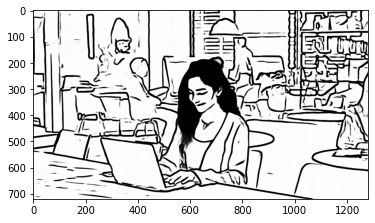

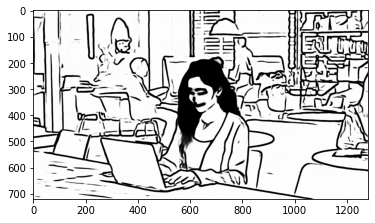

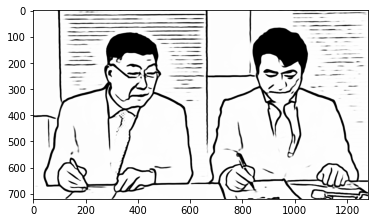

KeyboardInterrupt: 

In [42]:
impath = glob.glob("/home//ubuntu/workspace/kobaco/dataset/data_processing/kobaco_data/faces/original/**/*.jpg")
cnt = 0
for path in impath:
    if cnt % 10 == 0:
        lists = sketch(path)
        image = lists['image']
        jpg_original = base64.b64decode(image)
        jpg_as_np = np.frombuffer(jpg_original, dtype=np.uint8)
        img = cv2.imdecode(jpg_as_np, flags=1)
        plt.imshow(img)
        plt.show()
    cnt += 1
    print(cnt, end='\r')
#     if cnt == 200:
#         break


In [5]:
from matplotlib import pyplot as plt
import shutil
impath = glob.glob("/home//ubuntu/workspace/kobaco/dataset/data_processing/kobaco_data/faces/original/**/*.jpg")
# impath = glob.glob("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/sample/images/*")
print(impath[0])

# impath
cnt = 0
for path in impath:
    if cnt % 10 == 0:
        output_dir_gt = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/b2/'
        if(not os.path.exists(output_dir_gt)):
            os.mkdir(output_dir_gt)

        dst = path.split('/')[-1]
        
#         img = cv2.imread(path)
#         img_person = cv2.imread("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/sample/gt_thick_draw/" + dst[:-4] + '.png')
        img_person = sketch_bg(path)
#         plt.imshow(img)
#         plt.show()
#         plt.imshow(img_person)
#         plt.show()
        
#         dst_img = np.concatenate((img, img_person), axis=1)
        
#         plt.imshow(dst)
#         plt.show()
        
#         cv2.imwrite(output_dir_gt + dst[:-4] + '.png', dst_img)
        cv2.imwrite(output_dir_gt + dst[:-4] + '.png', img_person)
    cnt += 1
    print(cnt,end="\r")
    
    if cnt == 1000:
        break

# path = "/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/trainset_comb/bj1.PNG"
# img_person = sketch_bg(path)
# cv2.imwrite("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/trainset_comb/bj1_sk.png", img_person)

In [9]:
path = "0001.png"
img = cv2.imread(path)
img = img[:,:1280,:]


(720, 1280, 3)

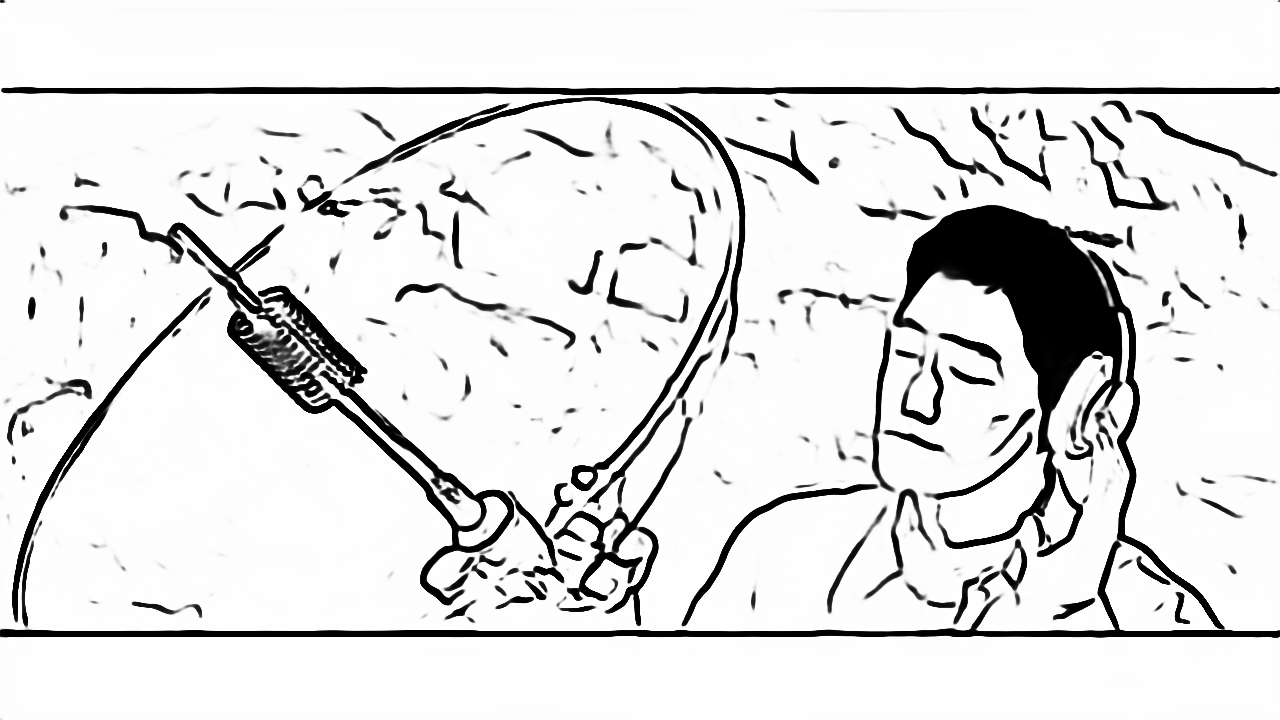

In [11]:
img_person = sketch_bg(img)
Image.fromarray(img_person)

In [ ]:
import os
import shutil

ori_path = glob.glob("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/datasets/dataset_affine61_180_selected/*.png")
dst_path = glob.glob("/home/ubuntu/workspace/kobaco/dataset/data_processing/kobaco_data/faces/original/**/*.jpg")

paths = []
for op in ori_path:
    paths.append(op.split('/')[-1])

for dp in dst_path:
    dst_file = dp.split('/')[-1][:-4] + '.png'
    if dst_file in paths:
        idx = paths.index(dst_file)
        src = ori_path[idx]
#         ori_img = cv2.imread(src)
#         dst_img = cv2.imread(dp)
        img = remove_bg(dp)
        out_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/datasets/im/'
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
#         img = cv2.imread(dp)
#         img, path = remove_bg(dp)
        
        dst = os.path.join(out_dir, dst_file[:-4] + '.jpg')
        
        cv2.imwrite(dst, img)
#         shutil.copy(dp, dst)

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

# impath = glob.glob("/home/ubuntu/workspace/kobaco/keyframe_json/result_sample/*")
impath = glob.glob("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/comb/im_val/*")
impath = impath[0:]
cnt = 0
for path in impath:
    img = cv2.imread(path)
    mask = get_mask(path)
    mask_inv = cv2.bitwise_not(mask)
    img_person = sketch_end(path)
    img_background = sketch_bg(path)

    img_fg = cv2.bitwise_and(img_person, img_person, mask=mask_inv)
    img_bg = cv2.bitwise_and(img_background, img_background, mask=mask)
    dst = img_fg + img_bg

#     fig = plt.figure(dpi=250)
#     rows, cols = 2, 2

#     ax0 = fig.add_subplot(rows, cols, 1)
#     ax0.imshow(img, cmap='gray')
#     ax0.axis("off")

#     ax0 = fig.add_subplot(rows, cols, 2)
#     ax0.imshow(img_person, cmap='gray')
#     ax0.axis("off")

#     ax0 = fig.add_subplot(rows, cols, 3)
#     ax0.imshow(img_background, cmap='gray')
#     ax0.axis("off")

#     ax0 = fig.add_subplot(rows, cols, 4)
#     ax0.imshow(dst, cmap='gray')
#     ax0.axis("off")

    output_dir_dst= '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/comb/gt_val/'
    if(not os.path.exists(output_dir_dst)):
        os.mkdir(output_dir_dst)
        
#     output_dir_bg= '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/comb/bg/'
#     if(not os.path.exists(output_dir_bg)):
#         os.mkdir(output_dir_bg)    
    
#     cv2.imwrite(output_dir_bg + path.split('/')[-1][:-4]+'.png', img_background)
    cv2.imwrite(output_dir_dst + path.split('/')[-1][:-4]+'.png', dst)
#     plt.savefig(output_dir_dst + path.split('/')[-1][:-4]+'.png')
    
    cnt+=1
    print(cnt, end='\r')
#     if cnt == 100:
#         break
#     plt.show()
#     input()
#     clear_output()

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

# impath = glob.glob("/home/ubuntu/workspace/kobaco/keyframe_json/result_sample/*")
impath = glob.glob("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/portrait_sample/im/*")
redir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/portrait_sample/result/'

cnt = 0
for i, path in enumerate(impath):
    img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = cv2.imread(redir + path.split('/')[-1][:-4] + '.png')

    dst = np.concatenate((img, result), axis=1)
    
    output_dir_dst= '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/portrait_sample/sample/'
    if(not os.path.exists(output_dir_dst)):
        os.mkdir(output_dir_dst)
        
#     output_dir_bg= '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/comb/bg/'
#     if(not os.path.exists(output_dir_bg)):
#         os.mkdir(output_dir_bg)    
    
#     cv2.imwrite(output_dir_bg + path.split('/')[-1][:-4]+'.png', img_background)
    cv2.imwrite(output_dir_dst + path.split('/')[-1][:-4]+'.png', dst)
#     plt.savefig(output_dir_dst + path.split('/')[-1][:-4]+'.png')
    
    cnt+=1
    print(cnt, end='\r')

In [2]:
import glob
ori_path = glob.glob("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/trainset_comb/dataset_sk/*.png")
len(ori_path)

50660

In [14]:
dst_path = glob.glob("/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/trainset_comb/dataset_gt/*.png")
len(dst_path)

30938

In [1]:
import json
import requests
dict = {}
dict['csvPath'] = 'csv.csv'
dict['type'] = 'FACE'
# dict['shape'] = ori_img.shape
target_url = 'http://123.214.171.148:10001/progress'

response = requests.post(target_url, data=json.dumps(dict))

KeyboardInterrupt: 